# Monte Carlo Dropout On Sparse Data set

## Import libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import norm


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import seaborn as sns
from matplotlib import pyplot as plt

import uncertainty_toolbox as uct

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

2022-08-22 16:24:56.955559: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 16:24:56.960661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 16:24:56.960674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and preprocess data

In [2]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)

#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## Model

In [68]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self,inputs):
        return super().call(inputs, training=True)
model = tf.keras.models.Sequential([        
			 tf.keras.layers.Dense(100,activation="relu"),
             tf.keras.layers.Dense(100,activation="relu"),
             tf.keras.layers.Dense(100,activation="relu"),
			 MCDropout(0.1),
             tf.keras.layers.Dense(10, activation="relu"),
			 MCDropout(0.1),
             tf.keras.layers.Dense(1, activation=None)
			 ])
model.compile(loss="mse", 
              optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001), 
              metrics=['mae'])

In [69]:
print("start training ...")
history = model.fit(X_train, y_train, epochs=150, validation_split=0.1,verbose = 0)
print("Done")
#model.summary()
#SAVE MODEL 
joblib.dump(model, "model_sparse.pkl")

start training ...
Done
INFO:tensorflow:Assets written to: ram://8fdbbaff-a3e4-4b43-9215-a6e51302324d/assets


['model_sparse.pkl']

### Results

#### Model Performance

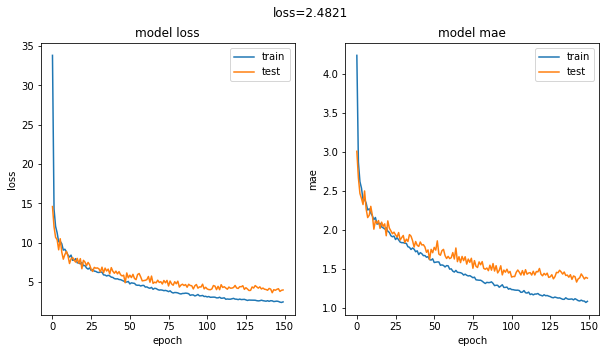

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.suptitle("loss={:5.4f}".format(history.history["loss"][-1]))

plt.show()

In [71]:
#predict output using the trained NeuralNet 
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

276/276 [==============================] - 0s 1ms/step


In [72]:
y_test = np.array(y_test)

In [73]:
# Calculate the error metrics
residuals = y_pred - y_test.reshape(-1)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mdae = median_absolute_error(y_test, y_pred)
marpd = np.abs(2 * residuals /
               (np.abs(y_pred) + np.abs(y_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(y_test, y_pred)
print("=========== Model Performance Metrics =========== ")
print(f" MAE   : {round(mae,3)} \n RMSE  : {round(rmse,3)} \n MDAE  : {round(mdae,3)} \n MARPD : {round(marpd,3)}")

=========== Model Performance Metrics =========== 
 MAE   : 1.483 
 RMSE  : 2.54 
 MDAE  : 1.003 
 MARPD : 35.901


#### Monte Carlo 

In [74]:
X_test=tf.convert_to_tensor(X_test) 

In [75]:
#make prediction using monte carlo simulation.
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

In [76]:
# make 100 forward pass
y_pred_dist = predict_dist(X_test, model,100)

In [77]:
print(f"y_pred {y_pred.shape} \ny_pred_dist {y_pred_dist.shape}")

y_pred (980, 1) 
y_pred_dist (980, 100)


In [78]:
#We have then 100 predictions, ie (y_1, y_2, ..., y_100), let's plot the mean and the variance.
prediction_distribution = y_pred_dist
prediction_mean = np.mean(np.array(prediction_distribution), axis=1)
prediction_stdv = np.std(np.array(prediction_distribution), axis=1)

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (2 * prediction_stdv)).tolist()
lower = (prediction_mean - (2 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()


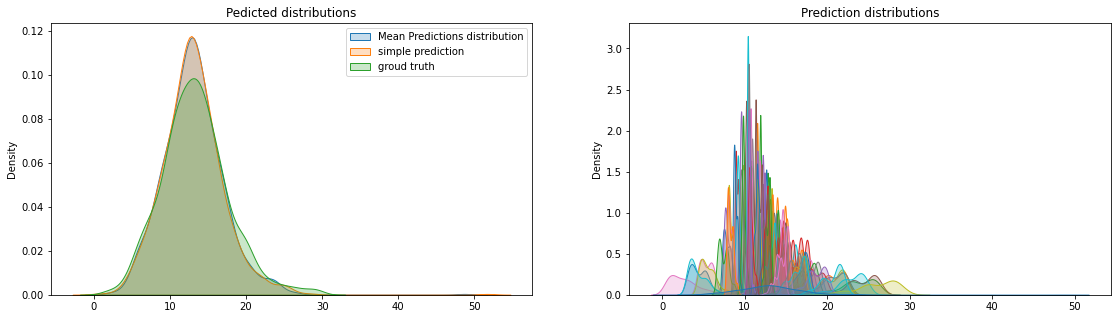

In [79]:
plt.figure(figsize=(19,5))
plt.subplot(1,2,1)
#sns.kdeplot(prediction_distribution[0], shade=True)
sns.kdeplot(prediction_mean, shade=True)
sns.kdeplot(y_pred.reshape(-1),shade=True)
sns.kdeplot(y_test, shade=True)
plt.legend(['Mean Predictions distribution','simple prediction','groud truth'])
plt.title('Pedicted distributions')
plt.subplot(1,2,2)
for i in range(len(prediction_distribution[0])):
    sns.kdeplot(prediction_distribution[i], shade=True)
    i = i+1
sns.kdeplot(prediction_mean, shade=True)
plt.title('Prediction distributions')

plt.show()

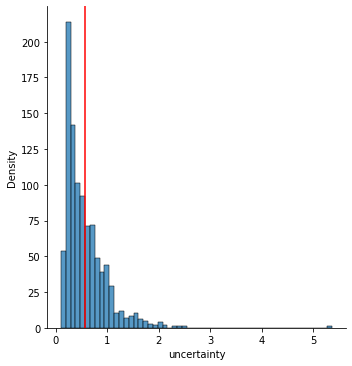

In [80]:
#plt.figure(figsize=(10,8))
sns.displot(prediction_stdv)
plt.axvline(np.mean(prediction_stdv), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

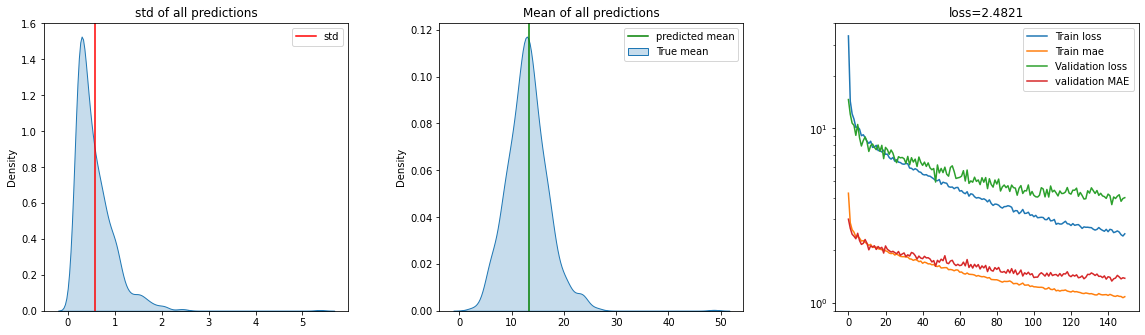

In [81]:
plt.figure(figsize=(19,5))
plt.subplot(1,3,1)
sns.kdeplot(prediction_stdv, shade=True)
plt.axvline(np.mean(prediction_stdv), color='red')
plt.title('std of all predictions')
plt.legend(['std'])

plt.subplot(1,3,2)
sns.kdeplot(prediction_mean, shade=True)
#plt.axvline(np.mean(p, color='red')
plt.axvline(np.mean(y_test), color='green')

plt.title('Mean of all predictions')
plt.legend(['predicted mean','True mean'])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)

plt.subplot(1,3,3)
for key in history.history.keys():
    plt.plot(history.history[key],label=key)
plt.title("loss={:5.4f}".format(history.history["loss"][-1]))
plt.legend(['Train loss','Train mae', 'Validation loss', 'validation MAE'])
plt.yscale('log')


plt.show()

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

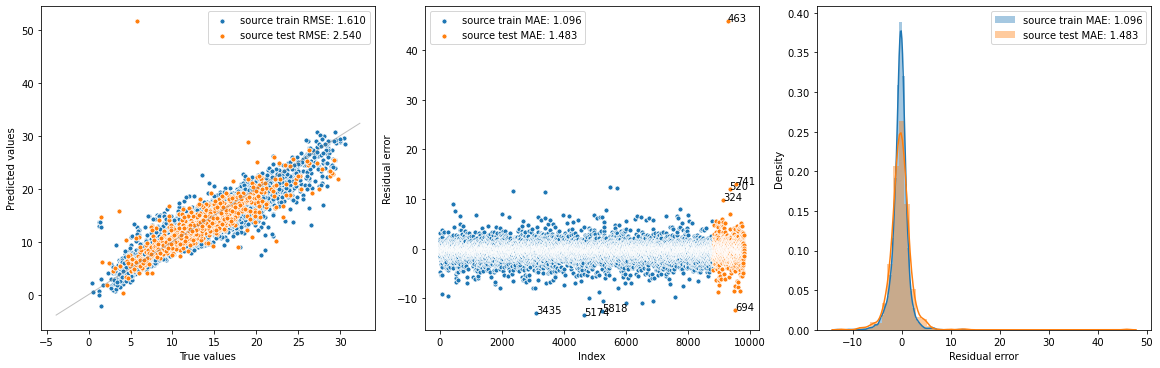

In [82]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); ax3 = fig.add_subplot(gs[0, 2]);

plot_adequation(y_train, y_train_pred, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_pred, label='source test', ax=ax1, plot_line=False, score='RMSE')

plot_residuals(y_train, y_train_pred, label='source train',ax=ax2,score='MAE',show_outliers=3)
plot_residuals(y_test, y_pred, index=len(y_train), label='source test', ax=ax2,score='MAE',show_outliers=5)

plot_residuals(y_train, y_train_pred, kind='hist', label='source train', ax=ax3, score='MAE')
plot_residuals(y_test, y_pred, kind='hist', label='source test', ax=ax3, score='MAE')

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

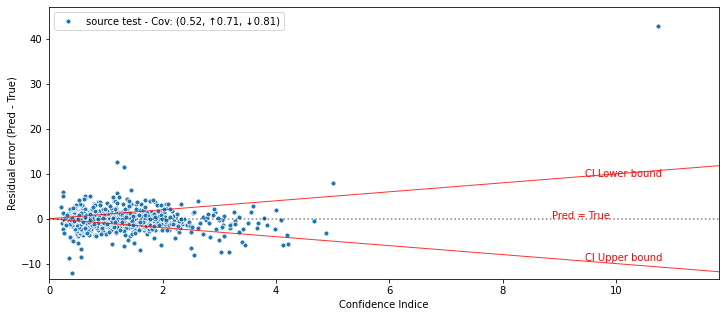

In [83]:
y_test_std = np.std(prediction_distribution, axis=1)
y_test_pred = np.mean(prediction_distribution, axis=1)
y_train_std = np.std(y_train_pred)
#plot_confidence_v2(y_train, y_train_pred, y_train_pred-2*y_train_std, y_train_pred+2*y_train_std, label='source train', cut=cut)
plot_confidence_v2(y_test,y_test_pred , y_test_pred-2*y_test_std,  y_test_pred+2*y_test_std, label='source test')

## Calibration

In [84]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(prediction_mean), np.array(prediction_stdv), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(prediction_stdv))

/NAS/USERS/e044432/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

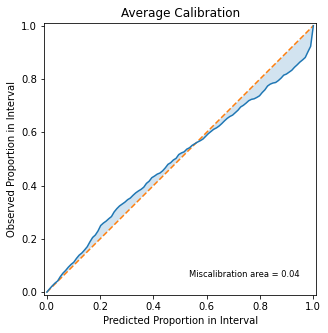

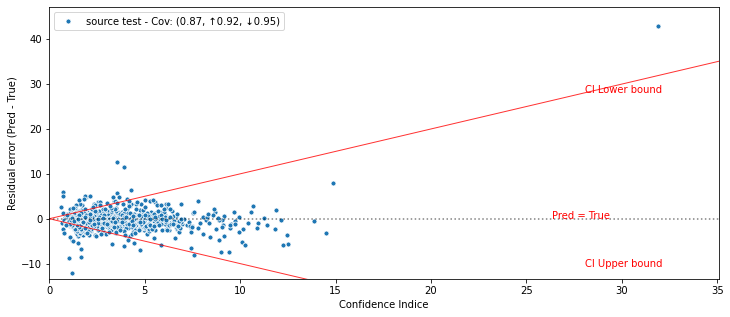

In [85]:
uct.viz.plot_calibration(np.array(prediction_mean),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(prediction_mean) ,np.array(prediction_mean)-2*new_stds, np.array(prediction_mean)+2*new_stds, label='source test')

In [93]:
y_pred = np.reshape(y_pred,y_test.shape)

In [94]:
metrics = uct.metrics.get_all_metrics(np.array(y_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.483
  RMSE          2.540
  MDAE          1.003
  MARPD         11.692
  R2            0.669
  Correlation   0.826
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.054
  Mean-absolute Calibration Error       0.039
  Miscalibration Area                   0.040
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.077
     Group Size: 0.56 -- Calibration Error: 0.055
     Group Size: 1.00 -- Calibration Error: 0.039
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.100
     Group Size: 0.56 -- Calibration Error: 0.067
     Group Size: 1.00 -- Calibration Error: 0.054
===============

### Save metrics

In [95]:
import pickle

In [96]:
with open('MCD_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(metrics, f)